# Ac-225 Advanced PSF Modeling (DICOM)

This tutorial uses the PSF operators obtained using the SPECTPSF toolbox to reconstruct Ac225 data. The operator was obtained using tutorial 5, available at this [link](https://github.com/lukepolson/SPECTPSFToolbox/blob/main/tutorials/5_optimization_ac225.ipynb). Use of this operator requires the SPECTPSFToolbox to be installed; instructions for installing can be found on the README [here](https://github.com/lukepolson/SPECTPSFToolbox/tree/main)

In [1]:
import matplotlib.pyplot as plt
import torch # needed for kernels
import pytomography
from pytomography.projectors.SPECT import SPECTSystemMatrix
from pytomography.io.SPECT import dicom
from pytomography.algorithms import OSEM
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.transforms.SPECT import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.transforms.shared import GaussianFilter
from pytomography.io.SPECT.shared import subsample_projections_and_modify_metadata
import dill
import os


          -  -  -  -  -  -  -  -   -  -  -  -
          P  A  R  A  L  L  E  L | P  R  O  J
          -  -  -  -  -  -  -  -   -  -  -  -


         Please consider citing our publication
      ---------------------------------------------
      Georg Schramm and Kris Thielemans:
      "PARALLELPROJ—an open-source framework for
       fast calculation of projections in
       tomography"
      Front. Nucl. Med., 08 January 2024
      Sec. PET and SPECT, Vol 3
      https://doi.org/10.3389/fnume.2023.1324562

 
    parallelproj C    lib: /data/anaconda/envs/pytomo_install_test/lib/libparallelproj_c.so.1.8.0
    parallelproj CUDA lib: /data/anaconda/envs/pytomo_install_test/lib/libparallelproj_cuda.so.1.8.0
    


Tutorial data path

In [2]:
path  = '/disk1/pytomography_tutorial_data'

Location of files

In [3]:
pathCT = os.path.join(path, 'ac225_tutorials', 'dicom', 'CT')
files_CT = [os.path.join(pathCT, file) for file in os.listdir(pathCT)]
file_NM = os.path.join(path, 'ac225_tutorials', 'dicom', 'projection_data.IMA')

Open the PSF operator created in [this tutorial](https://github.com/lukepolson/SPECTPSFToolbox/blob/main/tutorials/5_optimization_ac225.ipynb)

In [4]:
with open(os.path.join(path, 'ac225_tutorials', 'psf_operator_ac225.pkl'), 'rb') as f:
    psf_operator = dill.load(f)
    psf_operator.set_device(pytomography.device)

Define the peak, lower, and upper indices

In [5]:
index_peak = 3
index_lower = 4
index_upper = 5
object_meta, proj_meta = dicom.get_metadata(file_NM, index_peak=index_peak)
projections = dicom.get_projections(file_NM)
attenuation_map = dicom.get_attenuation_map_from_CT_slices(files_CT, file_NM, index_peak=index_peak, HU2mu_technique='from_cortical_bone_fit')

/data/home/gpuvmadm/PyTomography/src/pytomography/io/SPECT/attenuation_map.py:92: Warning: Could not find cortical bone peak: defaulting to 75% kVp value
  warnings.warn("Could not find cortical bone peak: defaulting to 75% kVp value", category=Warning)


Subsample the metadata and projections so that there are only 32 angles instead of 96. 

* When we obtain the scatter we also apply Gaussian blurring with standard deviations of 2 degrees, 0.48cm, and 0.48cm in the angular, radial, and axial directions respectively.

In [6]:
object_meta, proj_meta, projections = subsample_projections_and_modify_metadata(object_meta, proj_meta, projections, N_angle=3)
photopeak = projections[index_peak]
scatter = dicom.get_energy_window_scatter_estimate_projections(file_NM, projections, index_peak=index_peak, index_lower=index_lower, index_upper=index_upper, sigma_theta=2, sigma_r=0.48, sigma_z=0.48, proj_meta=proj_meta)

Define system matrix

In [7]:
att_transform = SPECTAttenuationTransform(attenuation_map=attenuation_map)
psf_transform = SPECTPSFTransform(psf_operator=psf_operator)
system_matrix = SPECTSystemMatrix(
        obj2obj_transforms = [att_transform,psf_transform],
        proj2proj_transforms = [],
        object_meta = object_meta,
        proj_meta = proj_meta)

Define likelihood and algorithm

In [8]:
likelihood = PoissonLogLikelihood(system_matrix, photopeak, scatter)
algorithm = OSEM(likelihood)

Reconstruct using MLEM 100it

In [9]:
recon = algorithm(n_iters=100, n_subsets=1)

Smooth the reconstructed image using a Gaussian filter with FWHM of 2cm.

In [10]:
filter = GaussianFilter(3) # 2cm FWHM
filter.configure(object_meta, proj_meta)
recon_smoothed = filter(recon)

Show an axial slice of the smoothed reconstruction. We'll also show the attenuation map in the background:

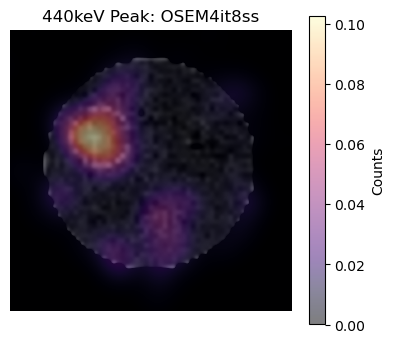

In [11]:
slice_pytomography = recon_smoothed.cpu()[:,:,70].T
slice_amap = attenuation_map.cpu()[:,:,70].T
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('440keV Peak: OSEM4it8ss')
plt.imshow(slice_amap, cmap='Greys_r', interpolation='gaussian', vmin=0.1)
plt.imshow(slice_pytomography, cmap='magma', interpolation='gaussian', alpha=0.5)
plt.axis('off')
plt.xlim(35,95)
plt.ylim(47,107)
plt.colorbar(label='Counts')
plt.show()

Activity can be seen in the largest sphere, which is of 60mm diameter. The smaller sphere at the bottom, which is of diameter 37mm, also appears to have some counts. The SPECT reconstructions are of poor quality since there is so little data collected in standard Ac225 protocols. Soon we will be releasing a paper showing the uncertainty in each of the spheres, as well as a high count reconstruction; the link to that will be shared here ASAP.